In [1]:
import sys
sys.path.append("..")
import MDAnalysis as mda
import nglview as nv
import matplotlib.pyplot as plt
import cellbell
import seaborn as sns
import pickle
import numpy as np
sns.set()
RANDOM_SEED = 281090

In [2]:
from MDAnalysis.analysis.dihedrals import Ramachandran, Janin

In [3]:
raw_data_dir = '../data/raw'
interim_data_dir = '../data/interim'
processed_data_dir = '../data/processed'
reports_dir = '../reports'

In [4]:
calculate = True

In [5]:
with open('../data/aa_resid_dic.pkl', 'rb') as my_file:
    aa_dic = pickle.load(my_file)

# Calculate dihedrals

In [6]:
def mda_janin_with_CSTV(u,selection):
    '''
    Takes in a MDAnalysis universe and a selection of that universe that contains
    one or several aminoacids sharing resid and resname. It calculates the regular
    Janin angles but if it is a CSTV it gives out only chi1 if it is a GAP it returns
    none.
      Parameters
      ----------
      u: MDAnalysis universe.
      selection: selection of the universe containing one or several aminoacids
                sharing resid and resname. 
      Returns
      -------
      output_angles: numpy array of angles, shape[n_frames, n_dihedrals, n_subunits]
    '''
    
    
    from MDAnalysis.analysis.dihedrals import Janin
    substitute = {
        'CYS': 'SG',
        'SER': 'OG',
        'THR': 'CG2',
        'VAL': 'CB1',
    }
    resname = np.unique(selection.resnames)
    resid = np.unique(selection.resids)
    assert resname.shape[0] != 1 or resid.shape[0] == 1, 'more than one resid'
    if resname[0] in ['CYS', 'SER', 'THR', 'VAL']:
        my_list = []
        for res in selection.residues:
            my_list0 =[]
            for ts in u.trajectory:
                chi1 = res.chi1_selection(cg_name=substitute[resname[0]]
                                   ).dihedral.value()
                my_list0.append(chi1)
            my_list.append(my_list0)
        output_angles = np.array(my_list)
        output_angles = output_angles.reshape([output_angles.shape[0],output_angles.shape[1],1])
        output_angles = output_angles + 180.
    else:
        try:
            output_angles = Janin(selection).run().angles
        except:
            output_angles = None
    return output_angles

In [7]:
res_list = [ 51, 59, 62, 64, 78, 96, 98, 99, 100, 102, 103, 107, 108, 111 ] 

In [8]:
nuclei_dic = {
    51: 'CB',
    59: 'N',
    62: 'C,CB,CA',
    64: 'CA',
    78: 'C,CA,CB,N',
    96: 'CB,N',
    98: 'CB',
    99: 'CA',
    100: 'N',
    102: 'CA,CB',
    103: 'N',
    107: 'CA',
    108: 'N',
    111: 'CB'
}

In [9]:
%%ding
if calculate:
    data = {}
    u_open = mda.Universe(f'{interim_data_dir}/3FB5_lb/protein_sk1_pbc.pdb',
                f'{interim_data_dir}/3FB5_lb/protein_sk1_pbc.xtc')
    u_fully_open = mda.Universe(f'{interim_data_dir}/5VK6_lb/protein_sk1_pbc.pdb',
                f'{interim_data_dir}/5VK6_lb/protein_sk1_pbc.xtc')
    for res_name in res_list:
        print(res_name)
        data[res_name] = {}
        for state_name,u in zip(['o', 'fo'],[u_open, u_fully_open]):
            res = u.select_atoms(f'resid {res_name}')
            data[res_name][state_name]= {}
            data[res_name][state_name]['ramachandran'] = Ramachandran(res).run().angles
            data[res_name][state_name]['janin'] = mda_janin_with_CSTV(u,res)
    with open(f'{processed_data_dir}/dihedrals.pkl', 'wb') as handle:
        pickle.dump(data, handle)
else:
    with open(f'{processed_data_dir}/dihedrals.pkl', 'rb') as handle:
        data = pickle.load(handle)

51
59
62
64
78
96
98


/home/sperez/data_partition/bin2/anaconda3/envs/lab_env/lib/python3.8/site-packages/MDAnalysis/analysis/dihedrals.py:464: UserWarning: All ALA, CYS, GLY, PRO, SER, THR, and VAL residues have been removed from the selection.
  warnings.warn("All ALA, CYS, GLY, PRO, SER, THR, and VAL residues"


99
100
102
103
107
108
111


51
59
62
64
78
96
98


No handles with labels found to put in legend.


99


No handles with labels found to put in legend.


100
102
103
107
108


No handles with labels found to put in legend.


111


No handles with labels found to put in legend.


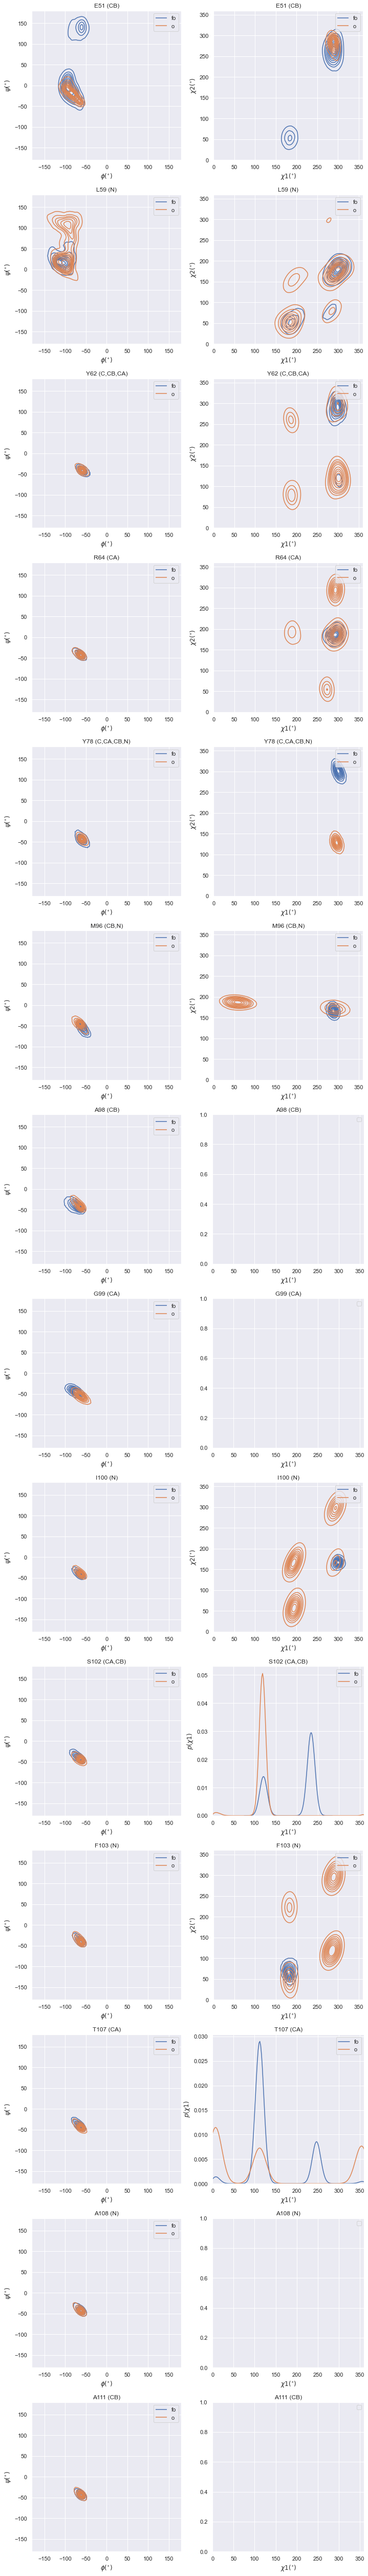

In [11]:
%%ding
fig, ax = plt.subplots(len(res_list), 2,sharex=False,sharey=False,figsize=(10,5*len(res_list)))
for i, res_name in enumerate(res_list):
    print(res_name)
    # Ramachandran
    a = data[res_name]['fo']['ramachandran']
    a = a.reshape([a.shape[0]*a.shape[1],2])
    sns.kdeplot(x=a[:,0],y=a[:,1],label='fo',ax=ax[i,0])
    a = data[res_name]['o']['ramachandran']
    a = a.reshape([a.shape[0]*a.shape[1],2])
    sns.kdeplot(x=a[:,0],y=a[:,1],label='o',ax=ax[i,0])
    ax[i,0].set_xlim([-180,180])
    ax[i,0].set_xlabel(r'$\phi (^{\circ})$')
    ax[i,0].set_ylabel(r'$\psi (^{\circ})$')
    ax[i,0].set_ylim([-180,180])
    ax[i,0].legend()
    ax[i,0].set_aspect('equal', 'box')
    ax[i,0].set_title(f'{aa_dic[res_name]}{res_name} ({nuclei_dic[res_name]})')
    # Janin
    a = data[res_name]['fo']['janin']
    if isinstance(a, np.ndarray):
        if a.shape[2] == 2:
            a = a.reshape([a.shape[0]*a.shape[1],2])
            sns.kdeplot(x=a[:,0],y=a[:,1],label='fo',ax=ax[i,1])
            a = data[res_name]['o']['janin']
            a = a.reshape([a.shape[0]*a.shape[1],2])
            sns.kdeplot(x=a[:,0],y=a[:,1],label='o',ax=ax[i,1])
            ax[i,1].set_ylabel(r'$\chi2 (^{\circ})$')
            ax[i,1].set_ylim([0,360])
            ax[i,1].set_aspect('equal', 'box')
        elif a.shape[2] == 1:
            a = a.reshape([a.shape[0]*a.shape[1]])
            sns.kdeplot(x=a[:],label='fo',ax=ax[i,1])
            a = data[res_name]['o']['janin']
            a = a.reshape([a.shape[0]*a.shape[1]])
            sns.kdeplot(x=a[:],label='o',ax=ax[i,1])
            ax[i,1].set_ylabel(r'$p(\chi1)$')
    ax[i,1].set_xlim([0,360])
    ax[i,1].set_xlabel(r'$\chi1 (^{\circ})$')
    ax[i,1].legend()
    ax[i,1].set_title(f'{aa_dic[res_name]}{res_name} ({nuclei_dic[res_name]})')
fig.tight_layout()
plt.savefig(f'{reports_dir}/figures/dihedral_analysis.png')